# Tutorial 3 - SPICE modules as hardcoded equations

In this tutorial, you will learn how to add hardcoded equations as SPICE modules.

In the previous tutorial, the equation for `x_reward_value_chosen` resembled the reward-prediction error.

The reward-prediction error is fairly well understood in cognitive science - also thanks to neuroimaging studies, which underlie the assumption about the classic mathematical form.

Therefore, the possible novel findings are quite limited here.

The learning rate on the other hand is in many studies assumed to be a constant and is also embedded in the SPICE-discovered equation as a fixed parameter. 
It can of course model asymmetric learning rates for rewards and penalties but is not adapting dynamically.

So what if we would like to find a dynamical equation which describes how the learning rate could possibly change with respect to rewards or the current value `x_reward_value_chosen`? 

The problem here is that we cannot just add another RNN-module in-line with `x_reward_value_chosen` which processes the same inputs.

This would result in two modules which would not have unique solutions.

Therefore, we have to disentangle here by adding knowledge about `x_reward_value_chosen` in the form of the classic reward-prediction error.

That way we are ending up with an additional RNN-module in the form of a hard-coded equation, and we have to expand the memory state by one variable which is the learning rate `x_learning_rate_reward`. 

Additionally, we are going to set the initial values for all memory state variables.

In the next section you will learn how to add hard-coded equations to the RNN.

As usual, we first start with the precoded model and then show how to implement it.

## 1. Data generation

Again, we simulate another synthetic dataset from a Q-learning agent.

In [1]:
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

In [2]:
from spice.resources.bandits import BanditsDrift, AgentQ, create_dataset

# Set up the environment
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

# Set up the agent
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.6,  # Learning rate for positive rewards 
    alpha_penalty=0.6,  # Learning rate for negative rewards
    forget_rate=0.3,
)

# Create the dataset
n_trials = 200
n_sessions = 256

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating dataset...


100%|██████████| 256/256 [00:01<00:00, 171.71it/s]


## 3. Using the precoded model with hardcoded equation

We first load the precoded model, which has the reward prediction error equation hardcoded as one of its modules. Additionally, it has an additional RNN module for the learning rate.

In [4]:
from spice.estimator import SpiceEstimator
from spice.precoded import LearningRateRNN, LEARNING_RATE_RNN_CONFIG

spice_estimator = SpiceEstimator(
    rnn_class=LearningRateRNN,
    spice_config=LEARNING_RATE_RNN_CONFIG,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    spice_optim_threshold=0.05,
    spice_optim_regularization=0.1,
    spice_participant_id=0,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)


Training the RNN...
Epoch 1/1024 --- L(Train): 1.5486179; Time: 0.11s; Convergence: 7.74e-01
Epoch 2/1024 --- L(Train): 0.9384844; Time: 0.10s; Convergence: 6.92e-01
Epoch 3/1024 --- L(Train): 0.7157739; Time: 0.10s; Convergence: 4.57e-01
Epoch 4/1024 --- L(Train): 0.6569334; Time: 0.11s; Convergence: 2.58e-01
Epoch 5/1024 --- L(Train): 0.6357561; Time: 0.10s; Convergence: 1.40e-01
Epoch 6/1024 --- L(Train): 0.6251904; Time: 0.10s; Convergence: 7.51e-02
Epoch 7/1024 --- L(Train): 0.6190645; Time: 0.10s; Convergence: 4.06e-02
Epoch 8/1024 --- L(Train): 0.6153351; Time: 0.10s; Convergence: 2.22e-02
Epoch 9/1024 --- L(Train): 0.6130227; Time: 0.11s; Convergence: 1.22e-02
Epoch 10/1024 --- L(Train): 0.6115318; Time: 0.10s; Convergence: 6.87e-03
Epoch 11/1024 --- L(Train): 0.6104788; Time: 0.10s; Convergence: 3.96e-03
Epoch 12/1024 --- L(Train): 0.6096293; Time: 0.10s; Convergence: 2.40e-03
Epoch 13/1024 --- L(Train): 0.6088547; Time: 0.10s; Convergence: 1.59e-03
Epoch 14/1024 --- L(Train)

  0%|          | 0/1 [00:00<?, ?it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.1500e-02 ... 7.5057e-02 ... 1.7616e-02 ... 1.1662e-01
(x_learning_rate_reward)[k+1] = 0.489 1 + 0.089 c_reward[k] + 0.125 c_value_reward[k]

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.7358e-03 ... 5.0000e-02 ... 2.1472e-02 ... 3.4208e-02
(x_value_reward_not_chosen)[k+1] = 0.166 1 + 0.693 x_value_reward_not_chosen[k]


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

SPICE training finished.
Training took 42.91 seconds.


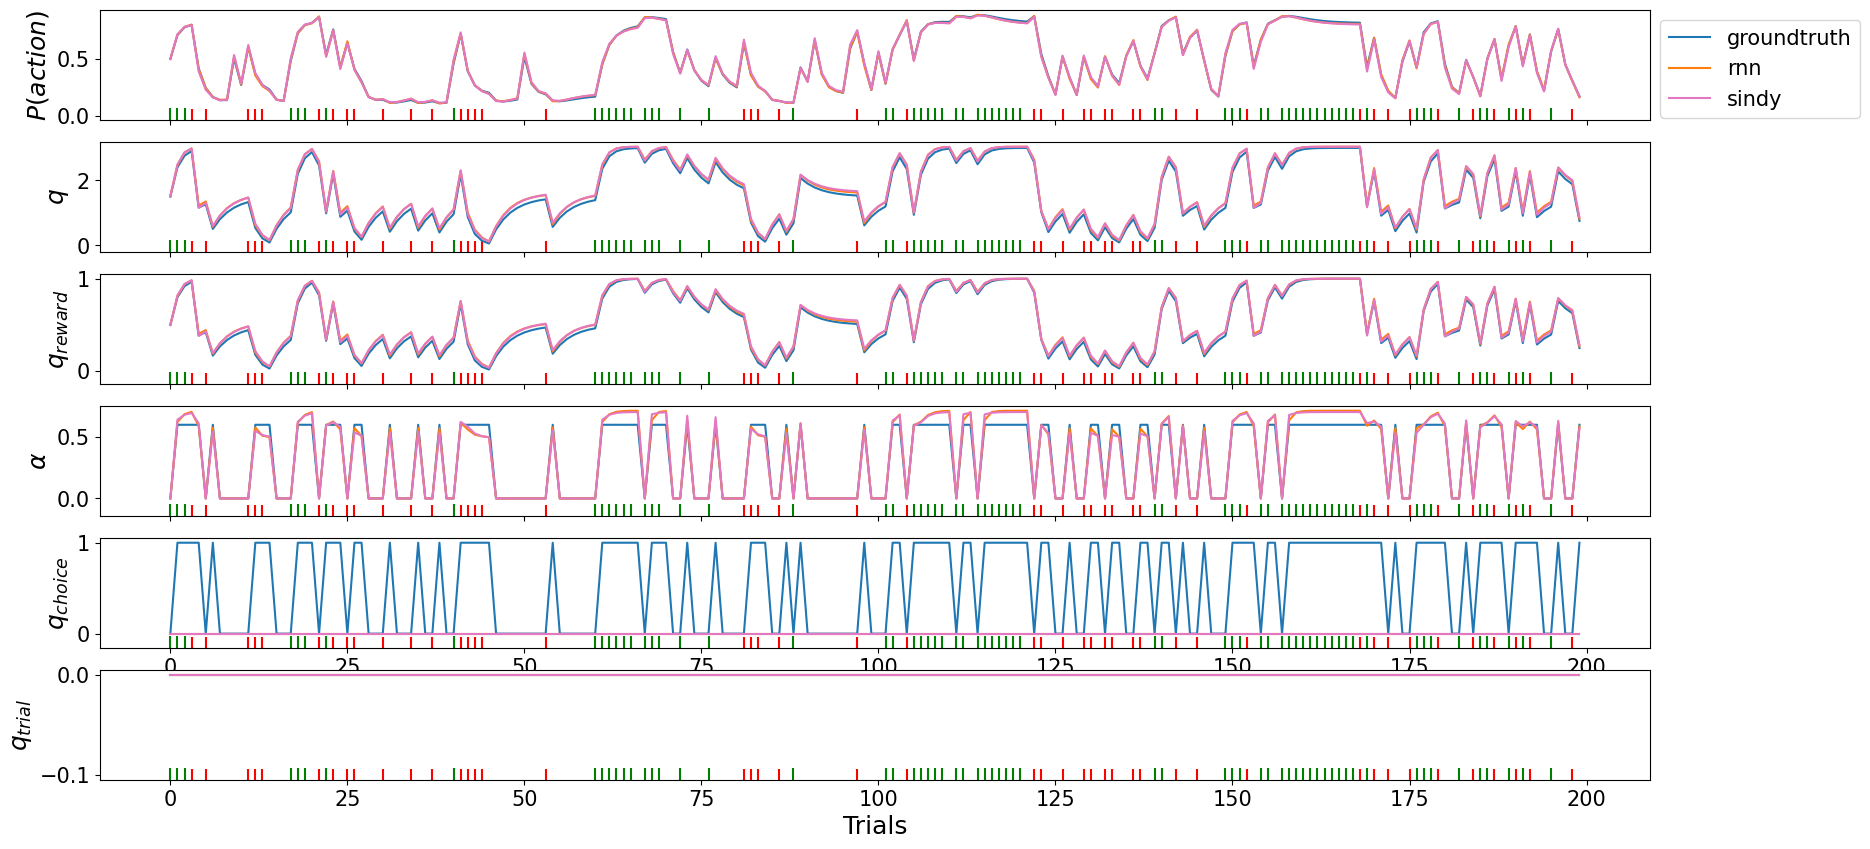

In [5]:
from spice.utils.plotting import plot_session
import matplotlib.pyplot as plt

# get analysis plot
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

## 3. Implementing the RNN as a custom module

Now, we are going to implement the RNN that discovers RW model with a forgetting mechanism. This RNN will update the values of both the chosen option, as in the previous tutorial, and has an additional module for the not chosen option.

In [6]:
from spice.resources.rnn import BaseRNN
from spice.estimator import SpiceConfig

CUSTOM_RNN_CONFIG = SpiceConfig(
    rnn_modules=['x_learning_rate_reward', 'x_value_reward_not_chosen'],
    
    control_parameters=['c_action', 'c_reward', 'c_value_reward'],

    library_setup={
        'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
        'x_value_reward_not_chosen': [],
    },

    filter_setup={
        'x_learning_rate_reward': ['c_action', 1, True],
        'x_value_reward_not_chosen': ['c_action', 0, True],
    },
)

class CustomLearningRateRNN(BaseRNN):
    
    init_values = {
            'x_value_reward': 0.5,
            'x_learning_rate_reward': 0,
    }
    
    def __init__(
        self,
        n_actions,
        **kwargs,
    ):
        super(CustomLearningRateRNN, self).__init__(n_actions=n_actions, list_signals=LEARNING_RATE_RNN_CONFIG.spice_feature_list)
        
        # set up the submodules
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0)

        # set up hard-coded equations
        # add here a RNN-module in the form of an hard-coded equation to compute the update for the chosen reward-based value
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)

        # add a scaling factor (i.e. inverse noise temperature) for 'x_value_reward'
        self.betas = torch.nn.ParameterDict()
        self.betas['x_value_reward'] = torch.nn.Parameter(torch.tensor(1.))             
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, ids, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs
                
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            self.record_signal('x_learning_rate_reward', self.state['x_learning_rate_reward'])
            
            # Let's compute the learning rate dynamically
            # Now we have to use a sigmoid activation function on the output learning rate to constrain it to a value range of (0, 1)
            # this is necessary for two reasons:
            #   1. Preventing exploding gradients
            #   2. Remember the found equation for 'x_value_reward_chosen' from before: 
            #       The learning rate was scaled according to the magnitudes of the reward and the actual value 
            #       e.g. for the reward: alpha*beta -> alpha * beta = 0.3 * 3 = 0.9 and for the reward-based value: 1-alpha = 1 - 0.3 = 0.7
            #       The hard-coded equation for the reward-prediction error does not permit this flexibility. 
            #       But we can circumvein this by applying the sigmoid activation to the learning rate to staying conform with the reward-prediction error
            #       and later applying the inverse noise temperature (i.e. trainable parameter) to the updated value 
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # Let's perform the belief update for the reward-based value of the chosen option            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                )
            
            # Update of the not-chosen reward-based value
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                )
            
            # updating the memory state
            self.state['x_learning_rate_reward'] = learning_rate_reward
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] * self.betas['x_value_reward']
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state() 

Library setup is valid. All keys and features appear in the provided list of features.


In [7]:
from spice.estimator import SpiceEstimator


spice_estimator = SpiceEstimator(
    rnn_class=CustomLearningRateRNN,
    spice_config=CUSTOM_RNN_CONFIG,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    spice_participant_id=0,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)


Training the RNN...
Epoch 1/1024 --- L(Train): 0.6913940; Time: 0.11s; Convergence: 6.54e-01
Epoch 2/1024 --- L(Train): 0.6583107; Time: 0.10s; Convergence: 3.44e-01
Epoch 3/1024 --- L(Train): 0.6383143; Time: 0.10s; Convergence: 1.82e-01
Epoch 4/1024 --- L(Train): 0.6228264; Time: 0.10s; Convergence: 9.87e-02
Epoch 5/1024 --- L(Train): 0.6098509; Time: 0.10s; Convergence: 5.58e-02
Epoch 6/1024 --- L(Train): 0.5995558; Time: 0.10s; Convergence: 3.31e-02
Epoch 7/1024 --- L(Train): 0.5921922; Time: 0.10s; Convergence: 2.02e-02
Epoch 8/1024 --- L(Train): 0.5874161; Time: 0.10s; Convergence: 1.25e-02
Epoch 9/1024 --- L(Train): 0.5841885; Time: 0.10s; Convergence: 7.86e-03
Epoch 10/1024 --- L(Train): 0.5814800; Time: 0.10s; Convergence: 5.28e-03
Epoch 11/1024 --- L(Train): 0.5789298; Time: 0.10s; Convergence: 3.92e-03
Epoch 12/1024 --- L(Train): 0.5765786; Time: 0.10s; Convergence: 3.13e-03
Epoch 13/1024 --- L(Train): 0.5744503; Time: 0.10s; Convergence: 2.63e-03
Epoch 14/1024 --- L(Train)

  0%|          | 0/1 [00:00<?, ?it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.1483e-02 ... 1.0826e-01 ... 5.6636e-02 ... 6.9202e-02
        10 ... 5.3955e-02 ... 1.1390e-01 ... 5.5250e-02 ... 1.1034e-01
(x_learning_rate_reward)[k+1] = 0.608 1

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.5834e-03 ... 1.8000e-01 ... 7.6734e-02 ... 8.0117e-02
        10 ... 8.4573e-02 ... 1.8000e-01 ... 7.3993e-02 ... 1.6037e-01
        20 ... 9.9954e-02 ... 1.8000e-01 ... 7.3742e-02 ... 1.7550e-01
        30 ... 1.0231e-01 ... 1.8000e-01 ... 7.3706e-02 ... 1.7781e-01
        40 ... 1.0265e-01 ... 1.8000e-01 ... 7.3701e-02 ... 1.7815e-01
        50 ... 1.0270e-01 ... 1.8000e-01 ... 7.3700e-02 ... 1.7820e-01
        60 ... 1.0270e-01 ... 1.8000e-01 ... 7.3700e-02 ... 1.7820e-01
(x_value_reward_not_chosen)[k+1] =

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

SPICE training finished.
Training took 24.56 seconds.


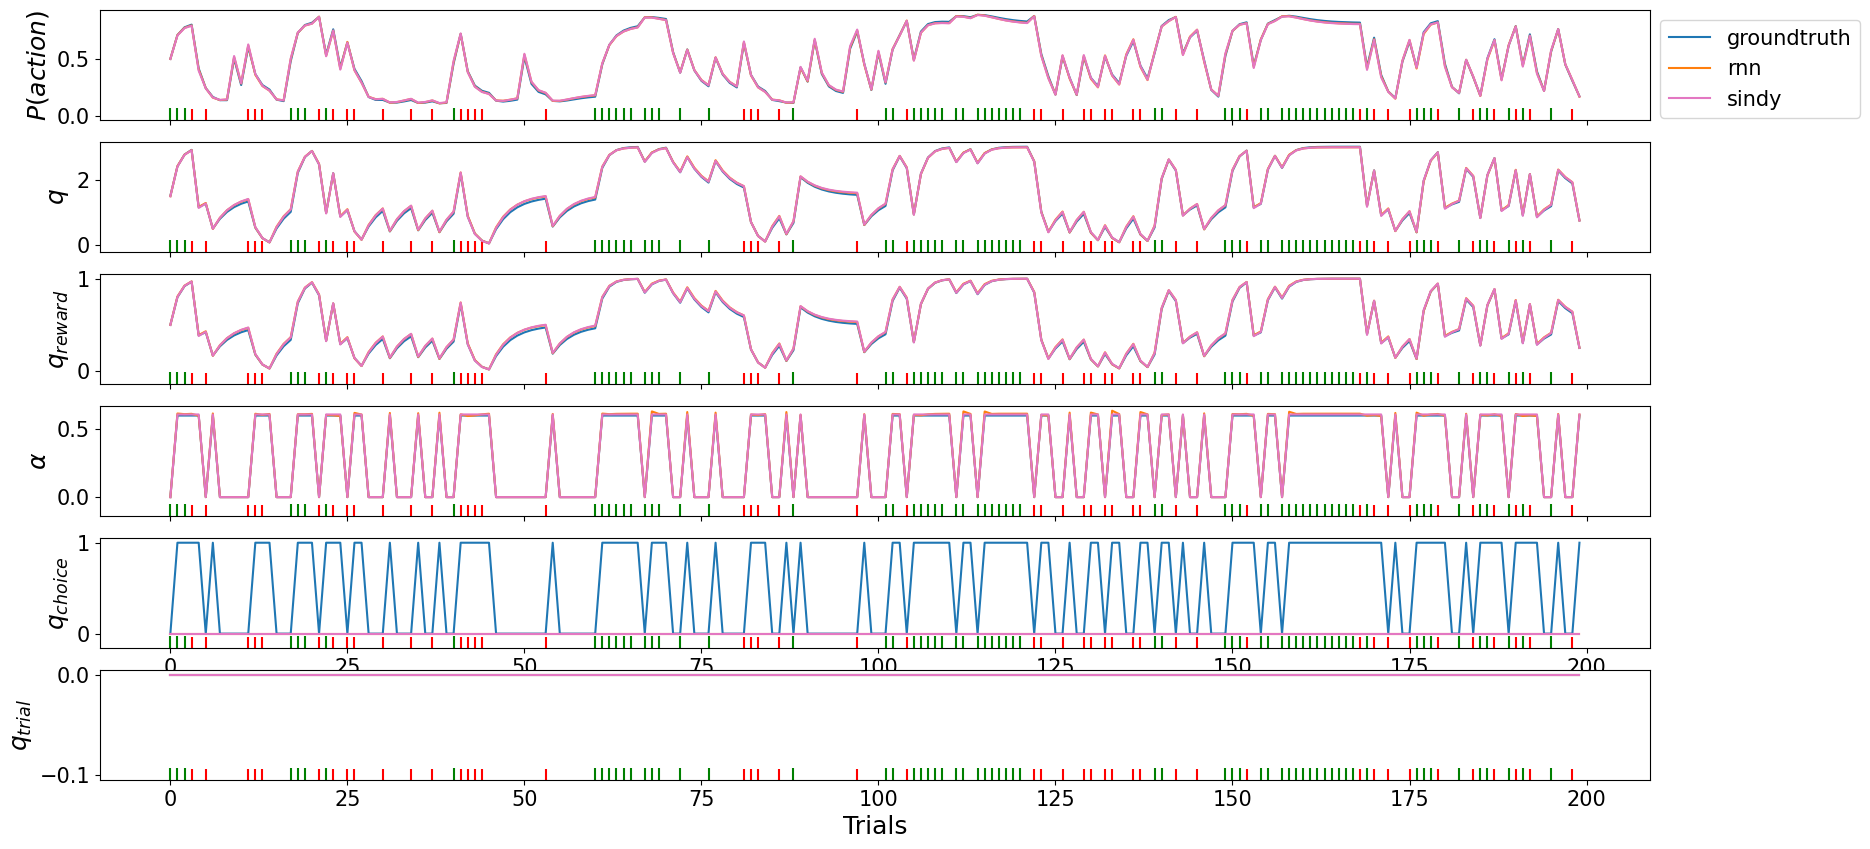

In [8]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

Now that we are making use of the established theories about the reward-prediction error in human reinforcement learning, we were able to to shift our focus on a less understood area i.e. the learning rate. In this example, the synthetic participant does not exhibit real dynamics in the sense of $\alpha_{t+1} = f(\alpha_{t})$, but the network is in principle equipped to learn also such a mechanism.